# Проект А/B тестирование

#### Тестируется новая механика оплаты
### Нужно ответить на следующие вопросы:
<ul style="font-size: 20px; line-height: 1.5;">
  <li>Какие метрики я анализирую и почему?</li>
  <li>Имеются ли различия в показателях и с чем они могут быть связаны?</li>
  <li>Являются ли эти различия статистически значимыми?</li>
  <li>Стоит ли запускать новую механику на всех пользователей?</li>
</ul>

### Также необходимо:
<ul style="font-size: 20px; line-height: 1.5;">
  <li>Реализовать функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv и на основании дополнительных параметров пересчитывать метрики.</li>
  <li>Реализовать функцию, которая будет строить графики по получаемым метрикам.</li>
</ul>

##### Описание данных:
groups.csv – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа).</br>
groups_add.csv – дополнительный файл с пользователями.</br>
active_studs.csv – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.</br>
checks.csv – файл с информацией об оплатах пользователей в дни проведения эксперимента. 

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Импортирую библиотеки
</div>

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import levene
from scipy.stats import median_test

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Данные загружены локально
</div>

In [29]:
df1 = pd.read_csv('Проект_2_groups.csv')
df2 = pd.read_csv('Проект_2_group_add.csv')
df3 = pd.read_csv('Проект_2_active_studs.csv')
df4 = pd.read_csv('Проект_2_checks.csv')

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Смотрю на вид и размеры данных
</div>

In [23]:
df1.head()

,id;grp
0,1489;B
1,1627;A
2,1768;B
3,1783;B
4,1794;A


In [24]:
df2.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [25]:
df3.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [26]:
df4.head()

,"student_id;""rev"""
0,1627;990.0
1,3185;690.0
2,25973;690.0
3,26280;690.0
4,100300;990.0


<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Проверяю пропуски в данных
</div>

In [12]:
df1.isna().sum()

id;grp    0
dtype: int64

In [7]:
df2.isna().sum()

id     0
grp    0
dtype: int64

In [8]:
df3.isna().sum()

student_id    0
dtype: int64

In [9]:
df4.isna().sum()

student_id;"rev"    0
dtype: int64

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Проверяю дубликаты
</div>

In [14]:
df1.duplicated().sum()

np.int64(0)

In [15]:
df2.duplicated().sum()

np.int64(0)

In [16]:
df3.duplicated().sum()

np.int64(0)

In [17]:
df4.duplicated().sum()

np.int64(0)

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Проверяю типы данных
</div>

In [19]:
df1.dtypes

id;grp    object
dtype: object

In [20]:
df2.dtypes

id      int64
grp    object
dtype: object

In [21]:
df3.dtypes

student_id    int64
dtype: object

In [22]:
df4.dtypes

student_id;"rev"    object
dtype: object

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
В данных нету пропусков и дубликатов. В некоторых дф необходимо разделить столбцы, переименовать student_id, исправить типы данных.
Логика объединения данных: к 1 дф добавляю 2 и далее объединяю с третим, оставляя только тех, кто участвовал в тесте. Далее добавляю revenue
</div>

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Разбиваю дф1 на 2 столбца
</div>

In [30]:
df1[['student_id', 'grp']] = df1['id;grp'].str.split(';', expand=True)
df1.drop(columns=['id;grp'], inplace=True)

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Разбиваю дф4 на 2 столбца
</div>

In [31]:
df4[['student_id', 'rev']] = df4['student_id;"rev"'].str.split(';', expand=True)
df4.drop(columns=['student_id;"rev"'], inplace=True)

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Переименовываю столбец дф2
</div>

In [32]:
df2.rename(columns={"id": "student_id"}, inplace=True)

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Привожу столбцы к нужным типам данных
</div>

In [33]:
df1['student_id'] = df1['student_id'].astype(str)
df2['student_id'] = df2['student_id'].astype(str)
df3['student_id'] = df3['student_id'].astype(str)
df4['student_id'] = df4['student_id'].astype(str)
df4['rev'] = df4['rev'].astype(float)

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Добавляю пользователей, которых скинули позже, к изначальным
</div>

In [34]:
df_1_2 = pd.concat([df1, df2], ignore_index=True)

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Оставляю только тех пользователей, которые заходили на платформу в дни проведения эксперимента</div>

In [35]:
df_filtred = pd.merge(df3, df_1_2, on='student_id', how='left')

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Добавляю колонку revenue</div>

In [36]:
df_filtred_rev = pd.merge(df_filtred, df4, on='student_id', how='left')

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Количество пользователей в группах</div>

In [37]:
df_filtred_rev['grp'].value_counts()

grp
B    6803
A    1538
Name: count, dtype: int64

Визуализация на графике

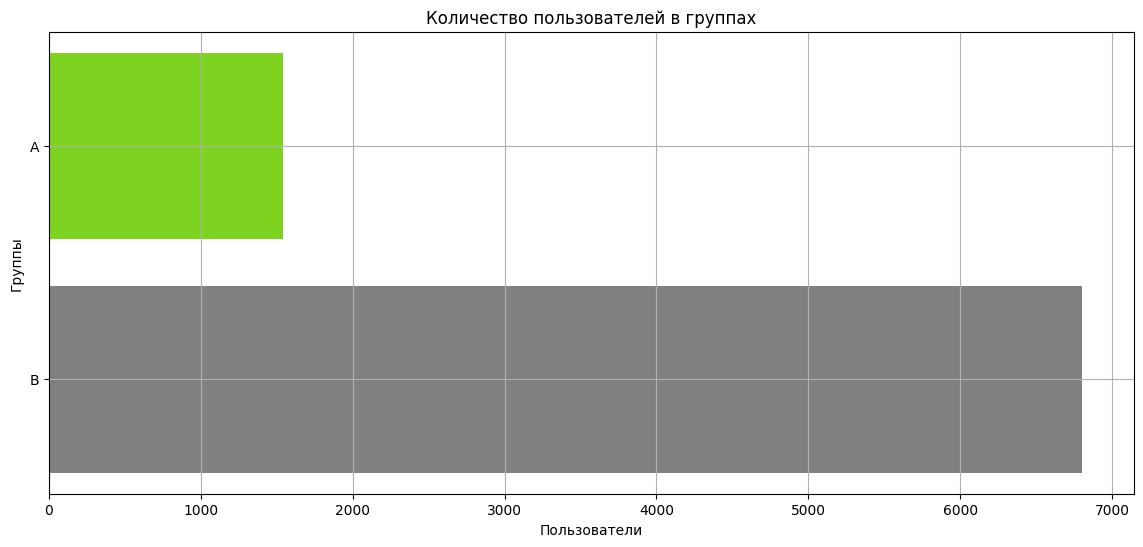

In [38]:
plt.figure(figsize=(14, 6))
plt.barh(df_filtred_rev['grp'].value_counts().index, df_filtred_rev['grp'].value_counts().values, color=['grey', '#7ED321'])
plt.xlabel('Пользователи')
plt.ylabel('Группы')
plt.title('Количество пользователей в группах')
plt.grid(True)
plt.show()

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Количество платящих пользователей</div>

In [39]:
paying_users_a = df_filtred_rev[df_filtred_rev['grp'] == 'A']['rev'].count()
paying_users_b = df_filtred_rev[df_filtred_rev['grp'] == 'B']['rev'].count()

print(f'A: {paying_users_a}')
print(f'B: {paying_users_b}')

A: 78
B: 314


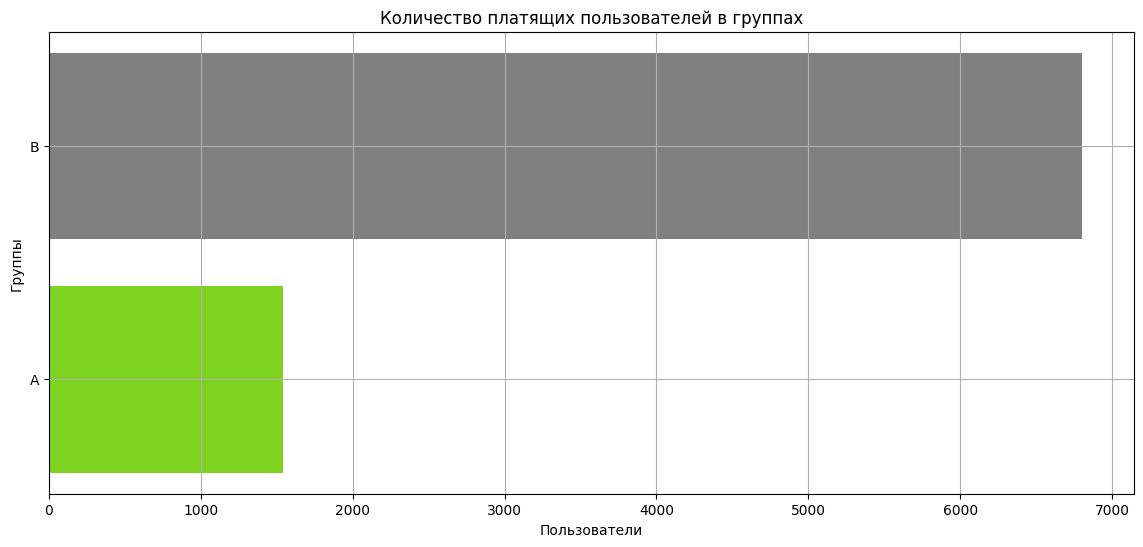

In [40]:
paying_users = df_filtred_rev.groupby('grp')['student_id'].count()

plt.figure(figsize=(14, 6))
plt.barh(paying_users.index, paying_users.values, color=['#7ED321', 'grey'])
plt.xlabel('Пользователи')
plt.ylabel('Группы')
plt.title('Количество платящих пользователей в группах')
plt.grid(True)
plt.show()

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Выручка в группах</div>

In [41]:
revenue_a = df_filtred_rev[df_filtred_rev['grp'] == 'A']['rev'].sum()
revenue_b = round(df_filtred_rev[df_filtred_rev['grp'] == 'B']['rev'].sum(), 0)

print(f'A: {revenue_a}')
print(f'B: {revenue_b}')

A: 72820.0
B: 394974.0


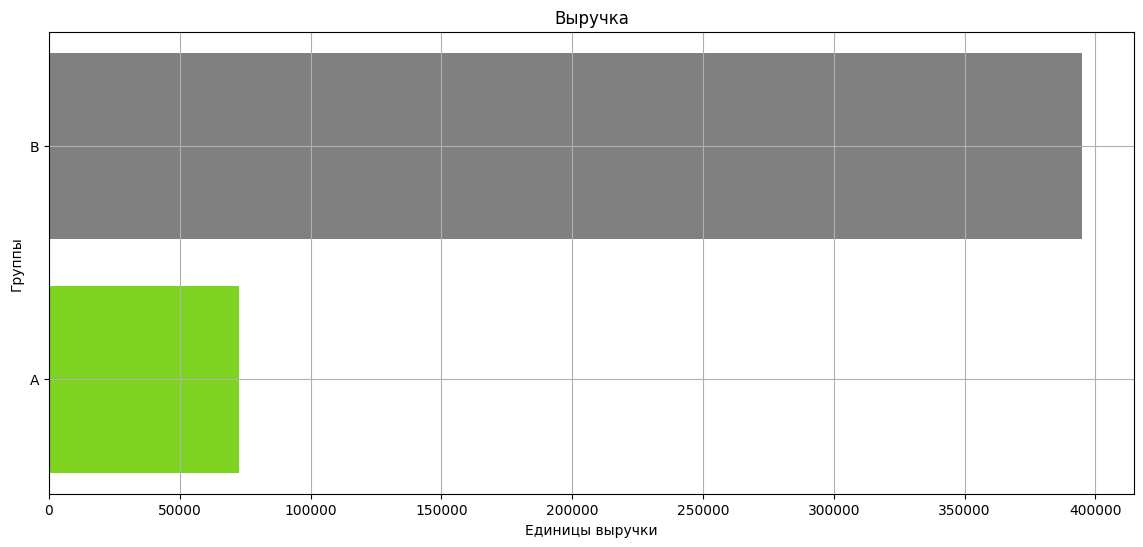

In [42]:
revenue_by_group = df_filtred_rev.groupby('grp')['rev'].sum()

plt.figure(figsize=(14, 6))
plt.barh(revenue_by_group.index, revenue_by_group.values, color=['#7ED321', 'grey'])
plt.xlabel('Единицы выручки')
plt.ylabel('Группы')
plt.title('Выручка')
plt.grid(True)
plt.show()

# Conversion Rate

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Считаю конверсию</div>

In [43]:
cr_group_a = (df_filtred_rev[df_filtred_rev['grp'] == 'A']['rev'].count() 
       / df_filtred_rev[df_filtred_rev['grp'] == 'A']['student_id'].count()) * 100

cr_group_b = (df_filtred_rev[df_filtred_rev['grp'] == 'B']['rev'].count() 
       / df_filtred_rev[df_filtred_rev['grp'] == 'B']['student_id'].count()) * 100

print(f"A: {round(cr_group_a, 2)}")
print(f"B: {round(cr_group_b, 2)}")

A: 5.07
B: 4.62


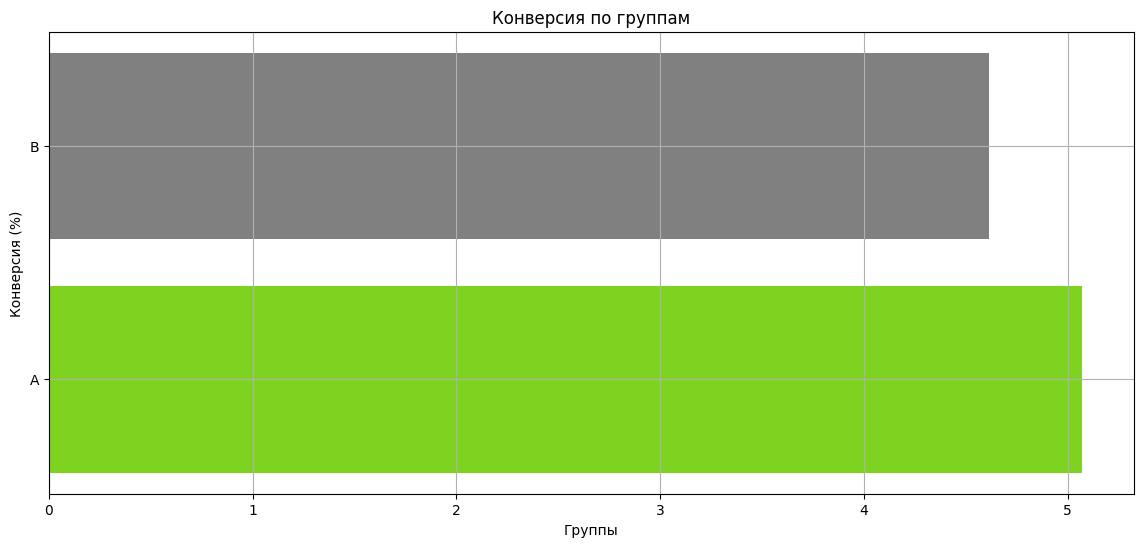

In [44]:
groups = ['A', 'B']
cr_values = [cr_group_a, cr_group_b]

plt.figure(figsize=(14, 6))
plt.barh(groups, cr_values, color=['#7ED321', 'grey'])
plt.xlabel('Группы')
plt.ylabel('Конверсия (%)')
plt.title('Конверсия по группам')
plt.grid(True)
plt.show()

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Разбиваю на группы для Z-теста</div>

In [45]:
# группа А
success_a = df_filtred_rev[df_filtred_rev['grp'] == 'A']['rev'].count()
total_a = df_filtred_rev[df_filtred_rev['grp'] == 'A']['student_id'].count()

# группа В
success_b = df_filtred_rev[df_filtred_rev['grp'] == 'B']['rev'].count()
total_b = df_filtred_rev[df_filtred_rev['grp'] == 'B']['student_id'].count()

success = [success_a, success_b]
total = [total_a, total_b]

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Провожу Z-тест. Н0 - Разницы между СR в группах нет</div>

In [46]:
proportions_ztest(success, total)

(np.float64(0.7629884495263746), np.float64(0.445470284371589))

P-value > 0.05 - отвергнуть H0 нельзя

# ARPU

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Разбиваю данные на группы и заменяю пропуски на 0 для проведения корректного стат теста ARPU</div>

In [47]:
arpu_group_a = df_filtred_rev[df_filtred_rev['grp'] == 'A']['rev'].fillna(0)
arpu_group_b = df_filtred_rev[df_filtred_rev['grp'] == 'B']['rev'].fillna(0)

print(f"A: {round(arpu_group_a.mean(), 1)}")
print(f"B: {round(arpu_group_b.mean(), 1)}")

A: 47.3
B: 58.1


<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Распределение ARPU</div>

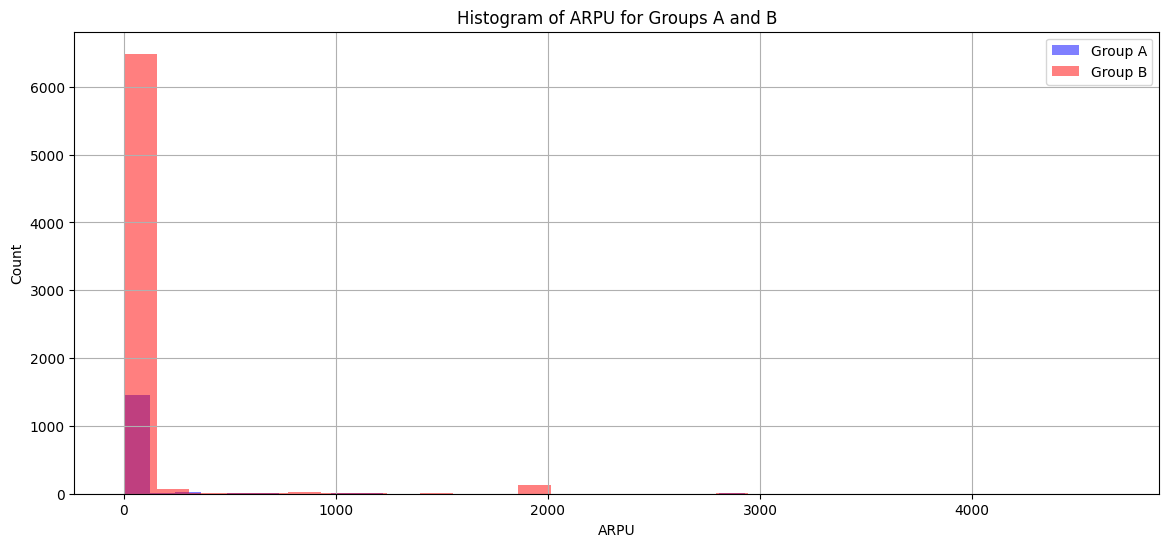

In [48]:
plt.figure(figsize=(14, 6))

plt.hist(arpu_group_a, bins=30, alpha=0.5, label='Group A', color='blue')
plt.hist(arpu_group_b, bins=30, alpha=0.5, label='Group B', color='red')

plt.title('Histogram of ARPU for Groups A and B')
plt.xlabel('ARPU')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Провожу Тест Левене на равенство дисперсий. Н0 - разницы в дисперсиях нет</div>

In [49]:
 levene(arpu_group_a, arpu_group_b)

LeveneResult(statistic=np.float64(1.5014608294336371), pvalue=np.float64(0.22048133327049668))

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
P value > 0.05 значит разницы в дисперсиях нет. Провожу Тест Медиан. Н0 - различий медиан в группах нет.</div>

In [50]:
median_test(arpu_group_a, arpu_group_b)

MedianTestResult(statistic=np.float64(0.484808265225579), pvalue=np.float64(0.48625240457231034), median=np.float64(0.0), table=array([[  78,  314],
       [1460, 6489]]))

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
P-value > 0.05, значит не отвергаю H0. Провожу бутстрап для сравнения различий средних значений. Н0 - различий в средних нет.</div>

In [51]:
arpu_iterations = 1000
arpu_differents = []

for _ in range(arpu_iterations):
    arpu_a_group_sample = np.random.choice(arpu_group_a, size=len(arpu_group_a), replace=True)
    arpu_b_group_sample = np.random.choice(arpu_group_b, size=len(arpu_group_b), replace=True)
    
    arpu_diff = np.mean(arpu_a_group_sample) - np.mean(arpu_b_group_sample)
    arpu_differents.append(arpu_diff)
    
arpu_lower_bound = np.percentile(arpu_differents, 2.5)
arpu_upper_bound = np.percentile(arpu_differents, 97.5)

print(f"95% доверительный интервал разницы средних: [{arpu_lower_bound:.2f}, {arpu_upper_bound:.2f}]")

95% доверительный интервал разницы средних: [-27.19, 6.69]


<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
0 входит в дипазон  - отвергнуть Н0 нельзя</div>

# ARPPU

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Разбиваю данные на группы и убираю пропуски для стат теста ARPPU</div>

In [52]:
arppu_group_a = df_filtred_rev[df_filtred_rev['grp'] == 'A']['rev'].dropna()
arppu_group_b = df_filtred_rev[df_filtred_rev['grp'] == 'B']['rev'].dropna()

print(f"A: {round(arppu_group_a.mean(), 1)}")
print(f"B: {round(arppu_group_b.mean(), 1)}")

A: 933.6
B: 1257.9


<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Распределение ARPPU</div>

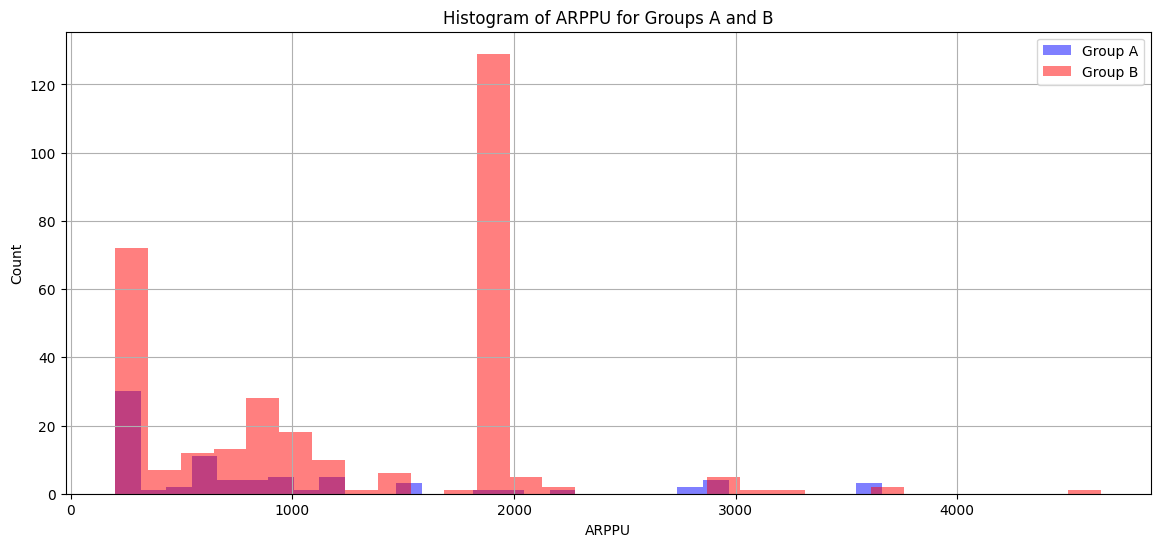

In [53]:
plt.figure(figsize=(14, 6))

plt.hist(arppu_group_a, bins=30, alpha=0.5, label='Group A', color='blue')
plt.hist(arppu_group_b, bins=30, alpha=0.5, label='Group B', color='red')

plt.title('Histogram of ARPPU for Groups A and B')
plt.xlabel('ARPPU')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Провожу Тест Левене на равенство дисперсий. Н0 - разницы в дисперсиях нет</div>

In [54]:
 levene(arppu_group_a, arppu_group_b)

LeveneResult(statistic=np.float64(3.0756816999816055), pvalue=np.float64(0.08025675761347023))

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
P value > 0.05 значит разницы в дисперсиях нет. Провожу Тест Медиан. Н0 - различий медиан в группах нет.</div>

In [55]:
median_test(arppu_group_a, arppu_group_b)

MedianTestResult(statistic=np.float64(15.441475980353815), pvalue=np.float64(8.509990112411958e-05), median=np.float64(990.0), table=array([[ 21, 165],
       [ 57, 149]]))

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
т.к pvalue < 0.05 - отвергаю Н0. Также провожу Бутстрап для сравнения средних. Н0 - различий в средних нет.</div>

In [64]:
arppu_iterations = 1000
arppu_differents = []

for _ in range(arppu_iterations):
    arppu_a_group_sample = np.random.choice(arppu_group_a, size=len(arppu_group_a), replace=True)
    arppu_b_group_sample = np.random.choice(arppu_group_b, size=len(arppu_group_b), replace=True)
    
    arppu_diff = np.mean(arppu_a_group_sample) - np.mean(arppu_b_group_sample)
    arppu_differents.append(arppu_diff)
    
arppu_lower_bound = np.percentile(arppu_differents, 2.5)
arppu_upper_bound = np.percentile(arppu_differents, 97.5)

print(f"95% доверительный интервал разницы средних: [{arppu_lower_bound:.2f}, {arppu_upper_bound:.2f}]")

95% доверительный интервал разницы средних: [-530.64, -96.68]


<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
Поскольку интервал не включает 0, то я отвергаю Н0</div>

# Вывод

<div style="background-color: #d9f2fa; padding: 10px; border-radius: 5px;">
В эксперементе я проанализировал количество пользователей, количество платящих, выручку, CR, ARPU, ARPPU.<br>
<br>
CR в целевой группе немного ниже. Это может быть связано с тем, что новая механика оплаты отрицательно сказалась на этом показателе. Однако, разница статистически незначительна и может быть случайной.<br>
<br>
ARPU выше в целевой группе, что может быть результатом более высоких платежей среди существующих платящих пользователей, хотя разница также статистически незначительна.<br>
<br>
ARPPU значительно выше в целевой группе, что подтверждается стат тестом, и может говорить о положительном влиянии новой механики оплаты среди платящих пользователей.<br>
<br>
Считаю, что пока рано раскатывать обновления на всех пользоватлей. Стоит провести еще тесты и посмотреть на поведение CR и ARPU и подумать, как увеличить эти метрики.
</div>

#### Функция для подгрузки информации из дополнительного файла groups_add.csv и пересчёта метрик на основе обновлённых данных.

In [65]:
def update_metrics(df1, df2, df3, df4):
    
    # объединение данных
    
    df_1_2 = pd.concat([df1, df2], ignore_index=True)
    df_filtred = pd.merge(df3, df_1_2, on='student_id', how='left')
    df_filtred_rev = pd.merge(df_filtred, df4, on='student_id', how='left')
    
    # метрики
    
    metrics = df_filtred_rev.groupby('grp').agg(
        USERS=('student_id', 'nunique'),
        PAYERS=('rev', 'count'),
        TOTAL_REV=('rev', 'sum'),
        ARPPU=('rev', lambda x: round(x.mean(), 1)),  # Средняя выручка на платящего 
        CR=('rev', lambda x: round(x.count() / len(x) * 100, 2)),  # Конверсия в платящих
        ARPU=('rev', lambda x: round(x.sum() / len(x), 1))  # Средняя выручка на пользователя
    ).reset_index()
    
    return metrics

metrics = update_metrics(df1, df2, df3, df4)
metrics['TOTAL_REV'] = metrics['TOTAL_REV'].astype(int)
metrics

,grp,USERS,PAYERS,TOTAL_REV,ARPPU,CR,ARPU
0,A,1538,78,72820,933.6,5.07,47.3
1,B,6803,314,394974,1257.9,4.62,58.1


#### Функция для построения графиков по получаемым метрикам.

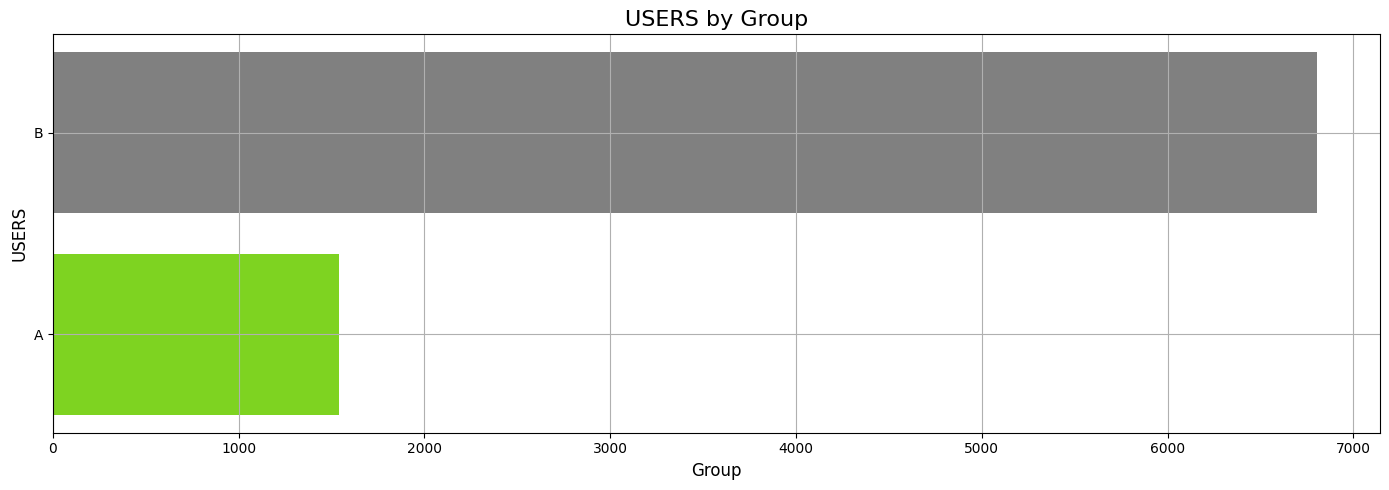

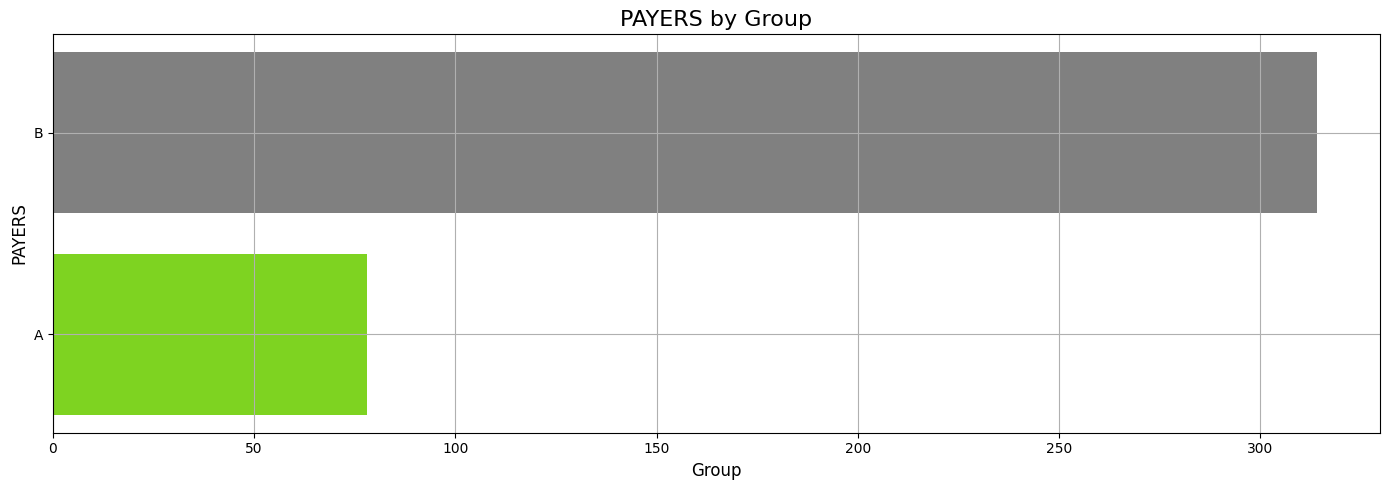

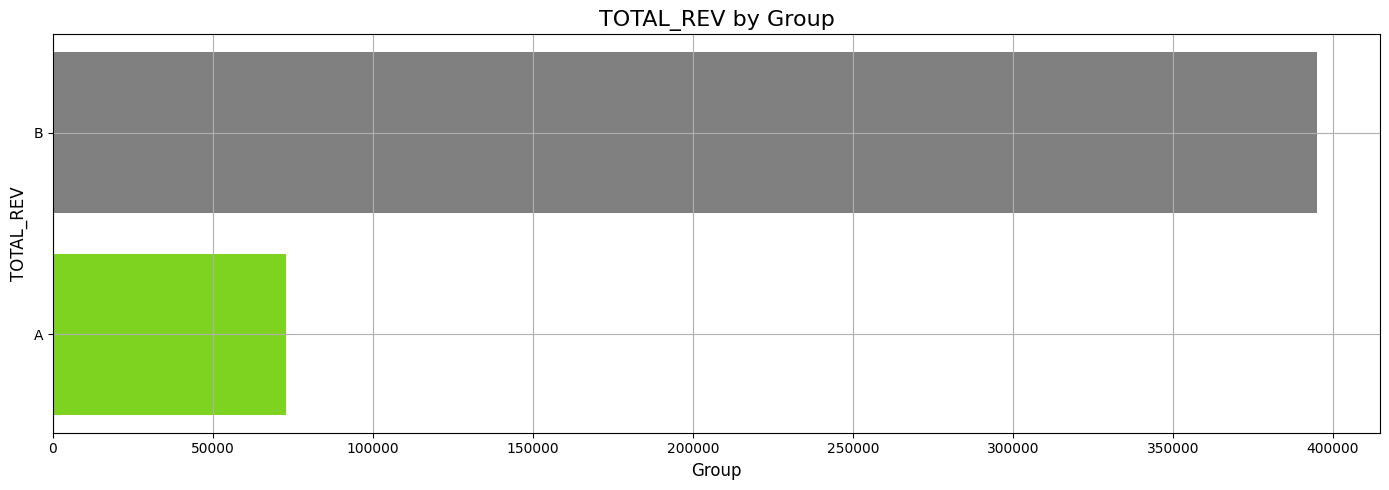

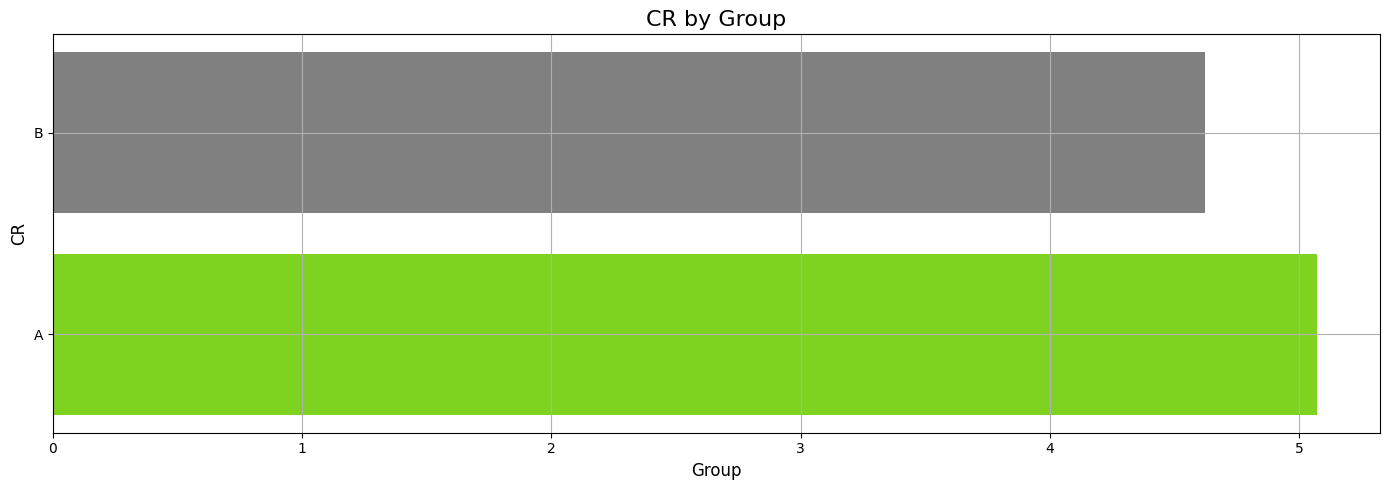

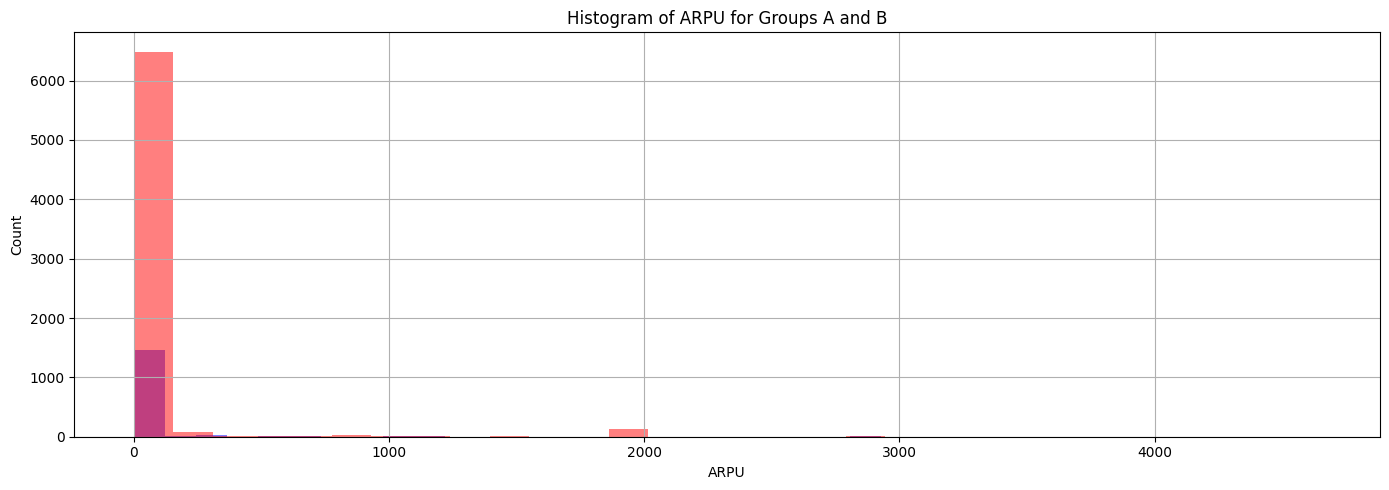

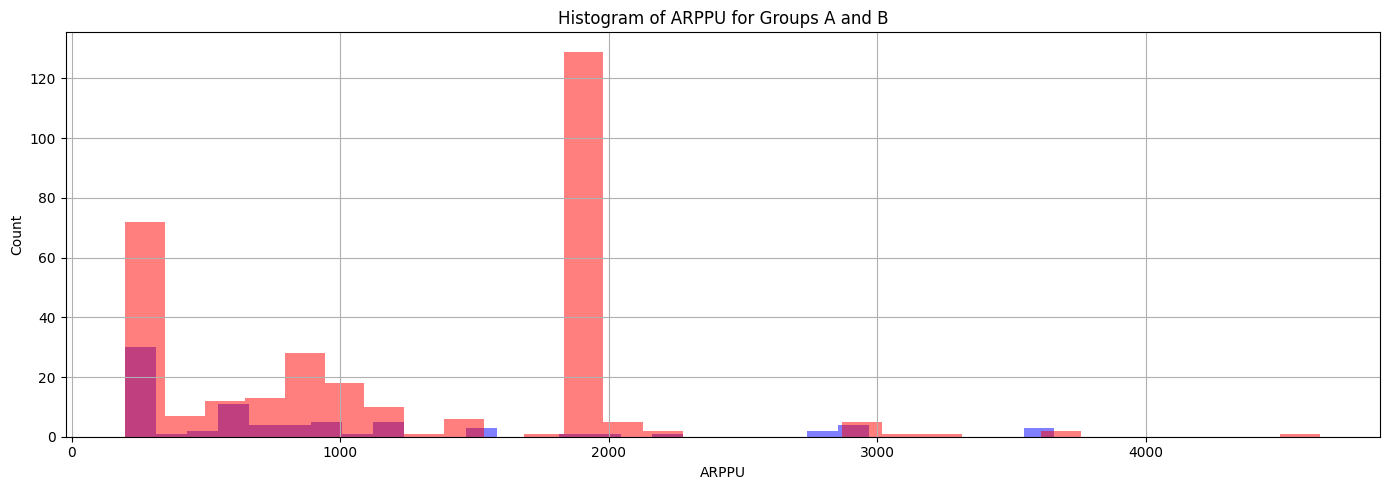

In [66]:
def bar_plots(metrics):
    
    # список для корректной интерации
    bar_metrics = ['USERS', 'PAYERS', 'TOTAL_REV', 'CR']

    # столбчатые диаграммы
    for metric in bar_metrics:
        plt.figure(figsize=(14, 5))
        plt.barh(metrics['grp'], metrics[metric], color=['#7ED321', 'grey'])
        plt.title(f'{metric} by Group', fontsize=16)
        plt.xlabel('Group', fontsize=12)
        plt.ylabel(metric, fontsize=12)
        plt.tight_layout()
        plt.grid(True)
        plt.show()
         
    # гистограммы распределения
def histograms(arpu_group_a, arpu_group_b, arppu_group_a, arppu_group_b):
   
    # ARPU
    plt.figure(figsize=(14, 5))
    plt.hist(arpu_group_a, bins=30, alpha=0.5, label='Group A', color='blue')
    plt.hist(arpu_group_b, bins=30, alpha=0.5, label='Group B', color='red')
    plt.title('Histogram of ARPU for Groups A and B')
    plt.xlabel('ARPU')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    # ARPPU
    plt.figure(figsize=(14, 5))
    plt.hist(arppu_group_a, bins=30, alpha=0.5, label='Group A', color='blue')
    plt.hist(arppu_group_b, bins=30, alpha=0.5, label='Group B', color='red')
    plt.title('Histogram of ARPPU for Groups A and B')
    plt.xlabel('ARPPU')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

bar_plots(metrics)
histograms(arpu_group_a, arpu_group_b, arppu_group_a, arppu_group_b)